In [47]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import swats
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pydot

Load signal and background trees

In [2]:
def min_max_renormal(numpy_array):
    mydf=pd.DataFrame(data=numpy_array)
    normalize_df=(mydf-mydf.min())/(mydf.max()-mydf.min())
    normalize_np=normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [3]:
signalFile=TFile.Open("4l-TMVA/tree_ewk_mytrain.root")
backgroundFile=TFile.Open("4l-TMVA/tree_QCD_mytrain.root")

In [4]:
signalTree=signalFile.Get("tree_NOMINAL")
backgroundTree=backgroundFile.Get("tree_NOMINAL")

In [5]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  223401
background events number before cut is:  279340


Convert minitree into numpy

In [6]:
signalArray=signalTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
backgroundArray=backgroundTree.AsMatrix(["weightr","MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

In [7]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

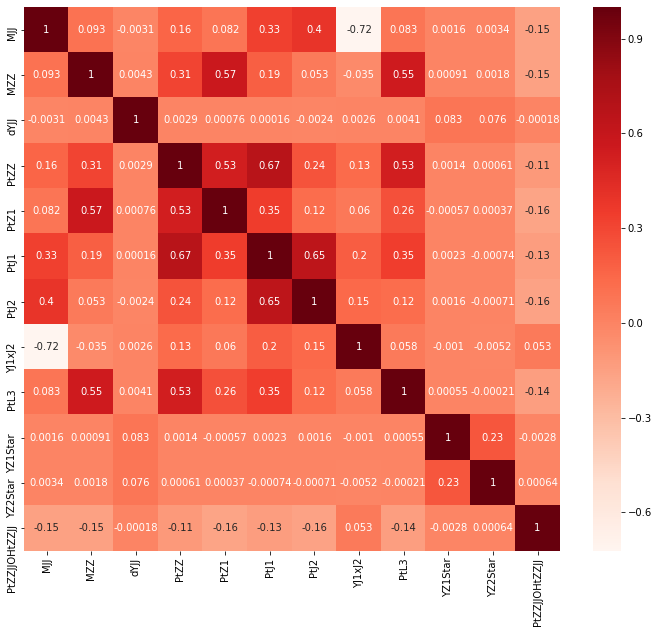

In [8]:
plt.figure(figsize=(12,10))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

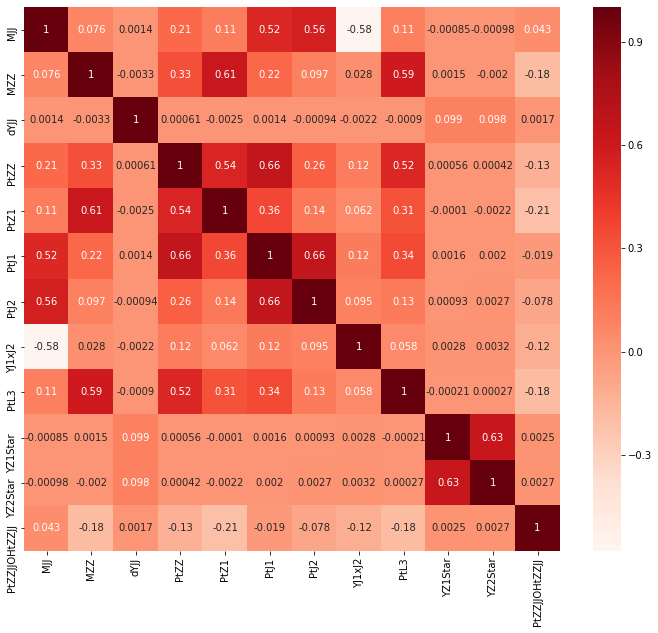

In [9]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [10]:
print(signalArray)

[[ 7.93955566e-05  1.10154873e+03  2.21385879e+02 ... -2.03438704e-01
  -7.17892966e-01  2.47319219e-01]
 [ 6.81283983e-05  8.88801935e+02  4.55076482e+02 ...  2.26838329e-01
  -6.34519528e-01  8.35550913e-02]
 [ 7.11882814e-05  1.39131227e+03  4.18144039e+02 ...  1.32187581e+00
  -1.33197312e+00  7.07480238e-02]
 ...
 [ 1.53771444e-04  8.24401842e+02  2.79273295e+02 ...  1.37421096e+00
   3.21475295e-01  2.03029652e-01]
 [ 1.43034199e-04  8.57515774e+02  1.86559830e+02 ... -4.43191963e-01
  -8.43641431e-01  1.82698382e-01]
 [ 2.06428744e-04  2.63357400e+03  3.88897812e+02 ...  9.54711913e-01
   1.37531098e+00  4.99991020e-02]]


In [11]:
print(signalArray[:,1])

[1101.54872881  888.80193472 1391.31226846 ...  824.4018424   857.51577443
 2633.5740049 ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [12]:
signalSample=signalArray[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [13]:
print(len(signalSample))
print(len(backgroundSample))

184569
100683


In [14]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  184569
background event number after cut is: 100683


Split datasets into training and testing subsets

In [15]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  147655
testing signal events number is:  36914
training background events number is:  80546
testing background events number is:  20137


In [16]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)

[[ 0.00000000e+00  6.21983734e-03  5.25015222e+02 ... -1.42999382e+00
  -1.66974657e+00  1.75535833e-01]
 [ 0.00000000e+00  6.98190858e-04  3.44016932e+02 ... -1.05546126e+00
  -2.03283716e+00  1.76130727e-01]
 [ 0.00000000e+00  1.24683477e-03  4.15262042e+02 ... -1.16850570e+00
  -1.21058080e-02  3.80503254e-02]
 ...
 [ 0.00000000e+00  1.33494477e-03  6.31518707e+02 ...  1.19336825e+00
   1.34136045e+00  1.45991868e-01]
 [ 0.00000000e+00  7.71906270e-04  4.57339323e+02 ... -2.84515429e+00
  -1.07520825e+00  1.15222805e-01]
 [ 0.00000000e+00  3.61952304e-03  6.06729492e+02 ... -4.34869950e-01
  -3.75516061e-01  1.24633166e-02]]


In [17]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]

Signal and background training sets should have same yield in training

(array([62.15855143,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 62.15855143]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

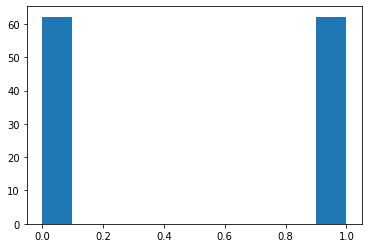

In [18]:
plt.hist(dataTrain[:,0],weights=dataTrain[:,1])

In [19]:
dataTrainSample1=min_max_renormal(dataTrainSample)

[[0.02938146 0.04672704 0.70992816 ... 0.71916011 0.90578632 0.59726852]
 [0.09350305 0.06169212 0.25773128 ... 0.61268247 0.44185986 0.10249915]
 [0.11475886 0.01811211 0.80118842 ... 0.7456784  0.74688097 0.08740394]
 ...
 [0.2669971  0.0857643  0.86166812 ... 0.68337575 0.66025573 0.05034852]
 [0.09977236 0.03231348 0.22322872 ... 0.49642875 0.42805331 0.09352759]
 [0.00963774 0.20821735 0.65897553 ... 0.45517585 0.74057544 0.03302825]]


Build model

In [32]:
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float).to(device)
WeightTensor=torch.tensor(dataTrainWeight, dtype=torch.float).to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float).to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=200, shuffle=False)

In [33]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300, 300)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(300, 300)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(300, 300)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(300, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [34]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [35]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data, target, sample_weight
        
        optimizer.zero_grad()
        target.unsqueeze(1)
        output = model(data)
        loss_function.weight = sample_weight/sample_weight.mean()
        loss = loss_function(output, target)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

In [36]:
model = Net().to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=12, out_features=300, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=300, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [37]:
loss_fn =nn.BCELoss().cuda()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [39]:
lowest_loss=9999
counter=0
best_epoch=0
pat=3
loss_np=np.zeros((300,1))
for epoch in range(1, 300):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_np[epoch-1]=loss_epoch
        if(loss_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break

/home/shuzhou/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train Epoch: 1 [0/228201 (0%)]	Loss: 0.695708
Train Epoch: 1 [2000/228201 (1%)]	Loss: 0.667327
Train Epoch: 1 [4000/228201 (2%)]	Loss: 0.674622
Train Epoch: 1 [6000/228201 (3%)]	Loss: 0.596065
Train Epoch: 1 [8000/228201 (4%)]	Loss: 0.655937
Train Epoch: 1 [10000/228201 (4%)]	Loss: 0.514300
Train Epoch: 1 [12000/228201 (5%)]	Loss: 0.621576
Train Epoch: 1 [14000/228201 (6%)]	Loss: 0.524174
Train Epoch: 1 [16000/228201 (7%)]	Loss: 0.519088
Train Epoch: 1 [18000/228201 (8%)]	Loss: 0.579371
Train Epoch: 1 [20000/228201 (9%)]	Loss: 0.472973
Train Epoch: 1 [22000/228201 (10%)]	Loss: 0.551031
Train Epoch: 1 [24000/228201 (11%)]	Loss: 0.510279
Train Epoch: 1 [26000/228201 (11%)]	Loss: 0.671585
Train Epoch: 1 [28000/228201 (12%)]	Loss: 0.537619
Train Epoch: 1 [30000/228201 (13%)]	Loss: 0.532307
Train Epoch: 1 [32000/228201 (14%)]	Loss: 0.497362
Train Epoch: 1 [34000/228201 (15%)]	Loss: 0.503005
Train Epoch: 1 [36000/228201 (16%)]	Loss: 0.390066
Train Epoch: 1 [38000/228201 (17%)]	Loss: 0.299947

/home/shuzhou/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train Epoch: 2 [10000/228201 (4%)]	Loss: 0.464265
Train Epoch: 2 [12000/228201 (5%)]	Loss: 0.375143
Train Epoch: 2 [14000/228201 (6%)]	Loss: 0.461448
Train Epoch: 2 [16000/228201 (7%)]	Loss: 0.432205
Train Epoch: 2 [18000/228201 (8%)]	Loss: 0.503810
Train Epoch: 2 [20000/228201 (9%)]	Loss: 0.453138
Train Epoch: 2 [22000/228201 (10%)]	Loss: 0.396204
Train Epoch: 2 [24000/228201 (11%)]	Loss: 0.431850
Train Epoch: 2 [26000/228201 (11%)]	Loss: 0.582112
Train Epoch: 2 [28000/228201 (12%)]	Loss: 0.465692
Train Epoch: 2 [30000/228201 (13%)]	Loss: 0.439057
Train Epoch: 2 [32000/228201 (14%)]	Loss: 0.458175
Train Epoch: 2 [34000/228201 (15%)]	Loss: 0.431506
Train Epoch: 2 [36000/228201 (16%)]	Loss: 0.376737
Train Epoch: 2 [38000/228201 (17%)]	Loss: 0.310537
Train Epoch: 2 [40000/228201 (18%)]	Loss: 0.793548
Train Epoch: 2 [42000/228201 (18%)]	Loss: 0.633376
Train Epoch: 2 [44000/228201 (19%)]	Loss: 0.455683
Train Epoch: 2 [46000/228201 (20%)]	Loss: 0.526697
Train Epoch: 2 [48000/228201 (21%)]	L

Train Epoch: 3 [100000/228201 (44%)]	Loss: 0.463322
Train Epoch: 3 [102000/228201 (45%)]	Loss: 0.435983
Train Epoch: 3 [104000/228201 (46%)]	Loss: 0.589205
Train Epoch: 3 [106000/228201 (46%)]	Loss: 0.483281
Train Epoch: 3 [108000/228201 (47%)]	Loss: 0.450830
Train Epoch: 3 [110000/228201 (48%)]	Loss: 0.483597
Train Epoch: 3 [112000/228201 (49%)]	Loss: 0.417074
Train Epoch: 3 [114000/228201 (50%)]	Loss: 0.389994
Train Epoch: 3 [116000/228201 (51%)]	Loss: 0.447011
Train Epoch: 3 [118000/228201 (52%)]	Loss: 0.584096
Train Epoch: 3 [120000/228201 (53%)]	Loss: 0.483320
Train Epoch: 3 [122000/228201 (53%)]	Loss: 0.629379
Train Epoch: 3 [124000/228201 (54%)]	Loss: 0.495854
Train Epoch: 3 [126000/228201 (55%)]	Loss: 0.466263
Train Epoch: 3 [128000/228201 (56%)]	Loss: 0.461177
Train Epoch: 3 [130000/228201 (57%)]	Loss: 0.492382
Train Epoch: 3 [132000/228201 (58%)]	Loss: 0.572968
Train Epoch: 3 [134000/228201 (59%)]	Loss: 0.418927
Train Epoch: 3 [136000/228201 (60%)]	Loss: 0.463033
Train Epoch:

Train Epoch: 4 [188000/228201 (82%)]	Loss: 0.444098
Train Epoch: 4 [190000/228201 (83%)]	Loss: 0.415277
Train Epoch: 4 [192000/228201 (84%)]	Loss: 0.490065
Train Epoch: 4 [194000/228201 (85%)]	Loss: 0.458205
Train Epoch: 4 [196000/228201 (86%)]	Loss: 0.407644
Train Epoch: 4 [198000/228201 (87%)]	Loss: 0.458284
Train Epoch: 4 [200000/228201 (88%)]	Loss: 0.444885
Train Epoch: 4 [202000/228201 (88%)]	Loss: 0.450763
Train Epoch: 4 [204000/228201 (89%)]	Loss: 0.398142
Train Epoch: 4 [206000/228201 (90%)]	Loss: 0.371391
Train Epoch: 4 [208000/228201 (91%)]	Loss: 0.444670
Train Epoch: 4 [210000/228201 (92%)]	Loss: 0.421759
Train Epoch: 4 [212000/228201 (93%)]	Loss: 0.540155
Train Epoch: 4 [214000/228201 (94%)]	Loss: 0.595389
Train Epoch: 4 [216000/228201 (95%)]	Loss: 0.465921
Train Epoch: 4 [218000/228201 (95%)]	Loss: 0.447281
Train Epoch: 4 [220000/228201 (96%)]	Loss: 0.381467
Train Epoch: 4 [222000/228201 (97%)]	Loss: 0.457693
Train Epoch: 4 [224000/228201 (98%)]	Loss: 0.468382
Train Epoch:

Train Epoch: 6 [50000/228201 (22%)]	Loss: 0.498672
Train Epoch: 6 [52000/228201 (23%)]	Loss: 0.384923
Train Epoch: 6 [54000/228201 (24%)]	Loss: 0.463410
Train Epoch: 6 [56000/228201 (25%)]	Loss: 0.451569
Train Epoch: 6 [58000/228201 (25%)]	Loss: 0.496446
Train Epoch: 6 [60000/228201 (26%)]	Loss: 0.452196
Train Epoch: 6 [62000/228201 (27%)]	Loss: 0.533392
Train Epoch: 6 [64000/228201 (28%)]	Loss: 0.428608
Train Epoch: 6 [66000/228201 (29%)]	Loss: 0.516239
Train Epoch: 6 [68000/228201 (30%)]	Loss: 0.503985
Train Epoch: 6 [70000/228201 (31%)]	Loss: 0.373192
Train Epoch: 6 [72000/228201 (32%)]	Loss: 0.488469
Train Epoch: 6 [74000/228201 (32%)]	Loss: 0.436328
Train Epoch: 6 [76000/228201 (33%)]	Loss: 0.498260
Train Epoch: 6 [78000/228201 (34%)]	Loss: 0.407704
Train Epoch: 6 [80000/228201 (35%)]	Loss: 0.483470
Train Epoch: 6 [82000/228201 (36%)]	Loss: 0.471082
Train Epoch: 6 [84000/228201 (37%)]	Loss: 0.434168
Train Epoch: 6 [86000/228201 (38%)]	Loss: 0.456748
Train Epoch: 6 [88000/228201 (3

Train Epoch: 7 [138000/228201 (60%)]	Loss: 0.428682
Train Epoch: 7 [140000/228201 (61%)]	Loss: 0.384861
Train Epoch: 7 [142000/228201 (62%)]	Loss: 0.467395
Train Epoch: 7 [144000/228201 (63%)]	Loss: 0.465407
Train Epoch: 7 [146000/228201 (64%)]	Loss: 0.461816
Train Epoch: 7 [148000/228201 (65%)]	Loss: 0.371620
Train Epoch: 7 [150000/228201 (66%)]	Loss: 0.524371
Train Epoch: 7 [152000/228201 (67%)]	Loss: 0.491858
Train Epoch: 7 [154000/228201 (67%)]	Loss: 0.495041
Train Epoch: 7 [156000/228201 (68%)]	Loss: 0.465607
Train Epoch: 7 [158000/228201 (69%)]	Loss: 0.406029
Train Epoch: 7 [160000/228201 (70%)]	Loss: 0.405553
Train Epoch: 7 [162000/228201 (71%)]	Loss: 0.418083
Train Epoch: 7 [164000/228201 (72%)]	Loss: 0.465733
Train Epoch: 7 [166000/228201 (73%)]	Loss: 0.361061
Train Epoch: 7 [168000/228201 (74%)]	Loss: 0.448392
Train Epoch: 7 [170000/228201 (74%)]	Loss: 0.575281
Train Epoch: 7 [172000/228201 (75%)]	Loss: 0.544660
Train Epoch: 7 [174000/228201 (76%)]	Loss: 0.401904
Train Epoch:

Train Epoch: 8 [228000/228201 (100%)]	Loss: 0.404188
Average loss in epoch  8  is:  0.4524258182444422
Train Epoch: 9 [0/228201 (0%)]	Loss: 0.407705
Train Epoch: 9 [2000/228201 (1%)]	Loss: 0.449171
Train Epoch: 9 [4000/228201 (2%)]	Loss: 0.412937
Train Epoch: 9 [6000/228201 (3%)]	Loss: 0.486132
Train Epoch: 9 [8000/228201 (4%)]	Loss: 0.588940
Train Epoch: 9 [10000/228201 (4%)]	Loss: 0.405930
Train Epoch: 9 [12000/228201 (5%)]	Loss: 0.377663
Train Epoch: 9 [14000/228201 (6%)]	Loss: 0.439891
Train Epoch: 9 [16000/228201 (7%)]	Loss: 0.416566
Train Epoch: 9 [18000/228201 (8%)]	Loss: 0.470620
Train Epoch: 9 [20000/228201 (9%)]	Loss: 0.428278
Train Epoch: 9 [22000/228201 (10%)]	Loss: 0.347489
Train Epoch: 9 [24000/228201 (11%)]	Loss: 0.406212
Train Epoch: 9 [26000/228201 (11%)]	Loss: 0.571778
Train Epoch: 9 [28000/228201 (12%)]	Loss: 0.458198
Train Epoch: 9 [30000/228201 (13%)]	Loss: 0.450450
Train Epoch: 9 [32000/228201 (14%)]	Loss: 0.430124
Train Epoch: 9 [34000/228201 (15%)]	Loss: 0.41320

Train Epoch: 10 [90000/228201 (39%)]	Loss: 0.482253
Train Epoch: 10 [92000/228201 (40%)]	Loss: 0.404010
Train Epoch: 10 [94000/228201 (41%)]	Loss: 0.558404
Train Epoch: 10 [96000/228201 (42%)]	Loss: 0.397715
Train Epoch: 10 [98000/228201 (43%)]	Loss: 0.420131
Train Epoch: 10 [100000/228201 (44%)]	Loss: 0.489676
Train Epoch: 10 [102000/228201 (45%)]	Loss: 0.448587
Train Epoch: 10 [104000/228201 (46%)]	Loss: 0.538455
Train Epoch: 10 [106000/228201 (46%)]	Loss: 0.464201
Train Epoch: 10 [108000/228201 (47%)]	Loss: 0.438334
Train Epoch: 10 [110000/228201 (48%)]	Loss: 0.478402
Train Epoch: 10 [112000/228201 (49%)]	Loss: 0.399477
Train Epoch: 10 [114000/228201 (50%)]	Loss: 0.365756
Train Epoch: 10 [116000/228201 (51%)]	Loss: 0.453282
Train Epoch: 10 [118000/228201 (52%)]	Loss: 0.543233
Train Epoch: 10 [120000/228201 (53%)]	Loss: 0.433581
Train Epoch: 10 [122000/228201 (53%)]	Loss: 0.624824
Train Epoch: 10 [124000/228201 (54%)]	Loss: 0.463493
Train Epoch: 10 [126000/228201 (55%)]	Loss: 0.44419

Train Epoch: 11 [178000/228201 (78%)]	Loss: 0.476263
Train Epoch: 11 [180000/228201 (79%)]	Loss: 0.535780
Train Epoch: 11 [182000/228201 (80%)]	Loss: 0.508262
Train Epoch: 11 [184000/228201 (81%)]	Loss: 0.454350
Train Epoch: 11 [186000/228201 (81%)]	Loss: 0.540237
Train Epoch: 11 [188000/228201 (82%)]	Loss: 0.435074
Train Epoch: 11 [190000/228201 (83%)]	Loss: 0.413868
Train Epoch: 11 [192000/228201 (84%)]	Loss: 0.435675
Train Epoch: 11 [194000/228201 (85%)]	Loss: 0.446789
Train Epoch: 11 [196000/228201 (86%)]	Loss: 0.418133
Train Epoch: 11 [198000/228201 (87%)]	Loss: 0.445374
Train Epoch: 11 [200000/228201 (88%)]	Loss: 0.436783
Train Epoch: 11 [202000/228201 (88%)]	Loss: 0.419636
Train Epoch: 11 [204000/228201 (89%)]	Loss: 0.374880
Train Epoch: 11 [206000/228201 (90%)]	Loss: 0.354358
Train Epoch: 11 [208000/228201 (91%)]	Loss: 0.440644
Train Epoch: 11 [210000/228201 (92%)]	Loss: 0.401390
Train Epoch: 11 [212000/228201 (93%)]	Loss: 0.532180
Train Epoch: 11 [214000/228201 (94%)]	Loss: 0.

Train Epoch: 13 [30000/228201 (13%)]	Loss: 0.440698
Train Epoch: 13 [32000/228201 (14%)]	Loss: 0.424729
Train Epoch: 13 [34000/228201 (15%)]	Loss: 0.409428
Train Epoch: 13 [36000/228201 (16%)]	Loss: 0.385430
Train Epoch: 13 [38000/228201 (17%)]	Loss: 0.353839
Train Epoch: 13 [40000/228201 (18%)]	Loss: 0.680645
Train Epoch: 13 [42000/228201 (18%)]	Loss: 0.604397
Train Epoch: 13 [44000/228201 (19%)]	Loss: 0.426917
Train Epoch: 13 [46000/228201 (20%)]	Loss: 0.484771
Train Epoch: 13 [48000/228201 (21%)]	Loss: 0.508594
Train Epoch: 13 [50000/228201 (22%)]	Loss: 0.491667
Train Epoch: 13 [52000/228201 (23%)]	Loss: 0.367136
Train Epoch: 13 [54000/228201 (24%)]	Loss: 0.466232
Train Epoch: 13 [56000/228201 (25%)]	Loss: 0.437995
Train Epoch: 13 [58000/228201 (25%)]	Loss: 0.506581
Train Epoch: 13 [60000/228201 (26%)]	Loss: 0.452426
Train Epoch: 13 [62000/228201 (27%)]	Loss: 0.515315
Train Epoch: 13 [64000/228201 (28%)]	Loss: 0.429687
Train Epoch: 13 [66000/228201 (29%)]	Loss: 0.476367
Train Epoch:

Train Epoch: 14 [118000/228201 (52%)]	Loss: 0.542320
Train Epoch: 14 [120000/228201 (53%)]	Loss: 0.455503
Train Epoch: 14 [122000/228201 (53%)]	Loss: 0.616096
Train Epoch: 14 [124000/228201 (54%)]	Loss: 0.475742
Train Epoch: 14 [126000/228201 (55%)]	Loss: 0.440936
Train Epoch: 14 [128000/228201 (56%)]	Loss: 0.418535
Train Epoch: 14 [130000/228201 (57%)]	Loss: 0.498341
Train Epoch: 14 [132000/228201 (58%)]	Loss: 0.561845
Train Epoch: 14 [134000/228201 (59%)]	Loss: 0.411547
Train Epoch: 14 [136000/228201 (60%)]	Loss: 0.456673
Train Epoch: 14 [138000/228201 (60%)]	Loss: 0.425015
Train Epoch: 14 [140000/228201 (61%)]	Loss: 0.381062
Train Epoch: 14 [142000/228201 (62%)]	Loss: 0.448846
Train Epoch: 14 [144000/228201 (63%)]	Loss: 0.445005
Train Epoch: 14 [146000/228201 (64%)]	Loss: 0.457747
Train Epoch: 14 [148000/228201 (65%)]	Loss: 0.394131
Train Epoch: 14 [150000/228201 (66%)]	Loss: 0.545219
Train Epoch: 14 [152000/228201 (67%)]	Loss: 0.468706
Train Epoch: 14 [154000/228201 (67%)]	Loss: 0.

Train Epoch: 15 [198000/228201 (87%)]	Loss: 0.454629
Train Epoch: 15 [200000/228201 (88%)]	Loss: 0.409856
Train Epoch: 15 [202000/228201 (88%)]	Loss: 0.428269
Train Epoch: 15 [204000/228201 (89%)]	Loss: 0.374355
Train Epoch: 15 [206000/228201 (90%)]	Loss: 0.344693
Train Epoch: 15 [208000/228201 (91%)]	Loss: 0.438816
Train Epoch: 15 [210000/228201 (92%)]	Loss: 0.394190
Train Epoch: 15 [212000/228201 (93%)]	Loss: 0.535992
Train Epoch: 15 [214000/228201 (94%)]	Loss: 0.544155
Train Epoch: 15 [216000/228201 (95%)]	Loss: 0.466748
Train Epoch: 15 [218000/228201 (95%)]	Loss: 0.464067
Train Epoch: 15 [220000/228201 (96%)]	Loss: 0.385430
Train Epoch: 15 [222000/228201 (97%)]	Loss: 0.442280
Train Epoch: 15 [224000/228201 (98%)]	Loss: 0.463367
Train Epoch: 15 [226000/228201 (99%)]	Loss: 0.467258
Train Epoch: 15 [228000/228201 (100%)]	Loss: 0.401170
Average loss in epoch  15  is:  0.4487871837177544
Train Epoch: 16 [0/228201 (0%)]	Loss: 0.410516
Train Epoch: 16 [2000/228201 (1%)]	Loss: 0.459086
Tra

Train Epoch: 17 [50000/228201 (22%)]	Loss: 0.495406
Train Epoch: 17 [52000/228201 (23%)]	Loss: 0.374532
Train Epoch: 17 [54000/228201 (24%)]	Loss: 0.446916
Train Epoch: 17 [56000/228201 (25%)]	Loss: 0.431594
Train Epoch: 17 [58000/228201 (25%)]	Loss: 0.503163
Train Epoch: 17 [60000/228201 (26%)]	Loss: 0.427962
Train Epoch: 17 [62000/228201 (27%)]	Loss: 0.530745
Train Epoch: 17 [64000/228201 (28%)]	Loss: 0.424138
Train Epoch: 17 [66000/228201 (29%)]	Loss: 0.505432
Train Epoch: 17 [68000/228201 (30%)]	Loss: 0.469889
Train Epoch: 17 [70000/228201 (31%)]	Loss: 0.372323
Train Epoch: 17 [72000/228201 (32%)]	Loss: 0.511447
Train Epoch: 17 [74000/228201 (32%)]	Loss: 0.418944
Train Epoch: 17 [76000/228201 (33%)]	Loss: 0.504164
Train Epoch: 17 [78000/228201 (34%)]	Loss: 0.398545
Train Epoch: 17 [80000/228201 (35%)]	Loss: 0.468446
Train Epoch: 17 [82000/228201 (36%)]	Loss: 0.447912
Train Epoch: 17 [84000/228201 (37%)]	Loss: 0.426774
Train Epoch: 17 [86000/228201 (38%)]	Loss: 0.448869
Train Epoch:

Train Epoch: 18 [140000/228201 (61%)]	Loss: 0.365743
Train Epoch: 18 [142000/228201 (62%)]	Loss: 0.457643
Train Epoch: 18 [144000/228201 (63%)]	Loss: 0.452827
Train Epoch: 18 [146000/228201 (64%)]	Loss: 0.453702
Train Epoch: 18 [148000/228201 (65%)]	Loss: 0.388569
Train Epoch: 18 [150000/228201 (66%)]	Loss: 0.500810
Train Epoch: 18 [152000/228201 (67%)]	Loss: 0.463895
Train Epoch: 18 [154000/228201 (67%)]	Loss: 0.477545
Train Epoch: 18 [156000/228201 (68%)]	Loss: 0.454365
Train Epoch: 18 [158000/228201 (69%)]	Loss: 0.405683
Train Epoch: 18 [160000/228201 (70%)]	Loss: 0.408945
Train Epoch: 18 [162000/228201 (71%)]	Loss: 0.411523
Train Epoch: 18 [164000/228201 (72%)]	Loss: 0.436514
Train Epoch: 18 [166000/228201 (73%)]	Loss: 0.349279
Train Epoch: 18 [168000/228201 (74%)]	Loss: 0.448604
Train Epoch: 18 [170000/228201 (74%)]	Loss: 0.555446
Train Epoch: 18 [172000/228201 (75%)]	Loss: 0.556756
Train Epoch: 18 [174000/228201 (76%)]	Loss: 0.387555
Train Epoch: 18 [176000/228201 (77%)]	Loss: 0.

Train Epoch: 19 [220000/228201 (96%)]	Loss: 0.388228
Train Epoch: 19 [222000/228201 (97%)]	Loss: 0.430035
Train Epoch: 19 [224000/228201 (98%)]	Loss: 0.457345
Train Epoch: 19 [226000/228201 (99%)]	Loss: 0.449691
Train Epoch: 19 [228000/228201 (100%)]	Loss: 0.392214
Average loss in epoch  19  is:  0.44638263847802856
Train Epoch: 20 [0/228201 (0%)]	Loss: 0.399441
Train Epoch: 20 [2000/228201 (1%)]	Loss: 0.478912
Train Epoch: 20 [4000/228201 (2%)]	Loss: 0.395316
Train Epoch: 20 [6000/228201 (3%)]	Loss: 0.485552
Train Epoch: 20 [8000/228201 (4%)]	Loss: 0.574117
Train Epoch: 20 [10000/228201 (4%)]	Loss: 0.391547
Train Epoch: 20 [12000/228201 (5%)]	Loss: 0.351658
Train Epoch: 20 [14000/228201 (6%)]	Loss: 0.427600
Train Epoch: 20 [16000/228201 (7%)]	Loss: 0.425064
Train Epoch: 20 [18000/228201 (8%)]	Loss: 0.476436
Train Epoch: 20 [20000/228201 (9%)]	Loss: 0.416726
Train Epoch: 20 [22000/228201 (10%)]	Loss: 0.344989
Train Epoch: 20 [24000/228201 (11%)]	Loss: 0.384948
Train Epoch: 20 [26000/22

Train Epoch: 21 [70000/228201 (31%)]	Loss: 0.369296
Train Epoch: 21 [72000/228201 (32%)]	Loss: 0.527516
Train Epoch: 21 [74000/228201 (32%)]	Loss: 0.424018
Train Epoch: 21 [76000/228201 (33%)]	Loss: 0.496795
Train Epoch: 21 [78000/228201 (34%)]	Loss: 0.394805
Train Epoch: 21 [80000/228201 (35%)]	Loss: 0.475922
Train Epoch: 21 [82000/228201 (36%)]	Loss: 0.431137
Train Epoch: 21 [84000/228201 (37%)]	Loss: 0.421723
Train Epoch: 21 [86000/228201 (38%)]	Loss: 0.453429
Train Epoch: 21 [88000/228201 (39%)]	Loss: 0.483592
Train Epoch: 21 [90000/228201 (39%)]	Loss: 0.480706
Train Epoch: 21 [92000/228201 (40%)]	Loss: 0.410044
Train Epoch: 21 [94000/228201 (41%)]	Loss: 0.544904
Train Epoch: 21 [96000/228201 (42%)]	Loss: 0.400345
Train Epoch: 21 [98000/228201 (43%)]	Loss: 0.397575
Train Epoch: 21 [100000/228201 (44%)]	Loss: 0.467462
Train Epoch: 21 [102000/228201 (45%)]	Loss: 0.443043
Train Epoch: 21 [104000/228201 (46%)]	Loss: 0.504922
Train Epoch: 21 [106000/228201 (46%)]	Loss: 0.447132
Train Ep

Train Epoch: 22 [152000/228201 (67%)]	Loss: 0.452398
Train Epoch: 22 [154000/228201 (67%)]	Loss: 0.479601
Train Epoch: 22 [156000/228201 (68%)]	Loss: 0.459960
Train Epoch: 22 [158000/228201 (69%)]	Loss: 0.403488
Train Epoch: 22 [160000/228201 (70%)]	Loss: 0.409831
Train Epoch: 22 [162000/228201 (71%)]	Loss: 0.418964
Train Epoch: 22 [164000/228201 (72%)]	Loss: 0.438899
Train Epoch: 22 [166000/228201 (73%)]	Loss: 0.351950
Train Epoch: 22 [168000/228201 (74%)]	Loss: 0.430747
Train Epoch: 22 [170000/228201 (74%)]	Loss: 0.530401
Train Epoch: 22 [172000/228201 (75%)]	Loss: 0.549001
Train Epoch: 22 [174000/228201 (76%)]	Loss: 0.378979
Train Epoch: 22 [176000/228201 (77%)]	Loss: 0.409370
Train Epoch: 22 [178000/228201 (78%)]	Loss: 0.468999
Train Epoch: 22 [180000/228201 (79%)]	Loss: 0.533674
Train Epoch: 22 [182000/228201 (80%)]	Loss: 0.500630
Train Epoch: 22 [184000/228201 (81%)]	Loss: 0.478342
Train Epoch: 22 [186000/228201 (81%)]	Loss: 0.528703
Train Epoch: 22 [188000/228201 (82%)]	Loss: 0.

Train Epoch: 24 [2000/228201 (1%)]	Loss: 0.452637
Train Epoch: 24 [4000/228201 (2%)]	Loss: 0.383601
Train Epoch: 24 [6000/228201 (3%)]	Loss: 0.474302
Train Epoch: 24 [8000/228201 (4%)]	Loss: 0.572862
Train Epoch: 24 [10000/228201 (4%)]	Loss: 0.379413
Train Epoch: 24 [12000/228201 (5%)]	Loss: 0.348377
Train Epoch: 24 [14000/228201 (6%)]	Loss: 0.425544
Train Epoch: 24 [16000/228201 (7%)]	Loss: 0.424137
Train Epoch: 24 [18000/228201 (8%)]	Loss: 0.474871
Train Epoch: 24 [20000/228201 (9%)]	Loss: 0.396203
Train Epoch: 24 [22000/228201 (10%)]	Loss: 0.354882
Train Epoch: 24 [24000/228201 (11%)]	Loss: 0.391758
Train Epoch: 24 [26000/228201 (11%)]	Loss: 0.543913
Train Epoch: 24 [28000/228201 (12%)]	Loss: 0.460979
Train Epoch: 24 [30000/228201 (13%)]	Loss: 0.441865
Train Epoch: 24 [32000/228201 (14%)]	Loss: 0.411802
Train Epoch: 24 [34000/228201 (15%)]	Loss: 0.400445
Train Epoch: 24 [36000/228201 (16%)]	Loss: 0.374403
Train Epoch: 24 [38000/228201 (17%)]	Loss: 0.356037
Train Epoch: 24 [40000/228

Train Epoch: 25 [92000/228201 (40%)]	Loss: 0.414529
Train Epoch: 25 [94000/228201 (41%)]	Loss: 0.525425
Train Epoch: 25 [96000/228201 (42%)]	Loss: 0.396681
Train Epoch: 25 [98000/228201 (43%)]	Loss: 0.369594
Train Epoch: 25 [100000/228201 (44%)]	Loss: 0.461011
Train Epoch: 25 [102000/228201 (45%)]	Loss: 0.443657
Train Epoch: 25 [104000/228201 (46%)]	Loss: 0.512588
Train Epoch: 25 [106000/228201 (46%)]	Loss: 0.461697
Train Epoch: 25 [108000/228201 (47%)]	Loss: 0.447701
Train Epoch: 25 [110000/228201 (48%)]	Loss: 0.480498
Train Epoch: 25 [112000/228201 (49%)]	Loss: 0.379963
Train Epoch: 25 [114000/228201 (50%)]	Loss: 0.374124
Train Epoch: 25 [116000/228201 (51%)]	Loss: 0.432335
Train Epoch: 25 [118000/228201 (52%)]	Loss: 0.541673
Train Epoch: 25 [120000/228201 (53%)]	Loss: 0.444901
Train Epoch: 25 [122000/228201 (53%)]	Loss: 0.628412
Train Epoch: 25 [124000/228201 (54%)]	Loss: 0.459197
Train Epoch: 25 [126000/228201 (55%)]	Loss: 0.447071
Train Epoch: 25 [128000/228201 (56%)]	Loss: 0.4158

Train Epoch: 26 [172000/228201 (75%)]	Loss: 0.550898
Train Epoch: 26 [174000/228201 (76%)]	Loss: 0.377977
Train Epoch: 26 [176000/228201 (77%)]	Loss: 0.400487
Train Epoch: 26 [178000/228201 (78%)]	Loss: 0.476718
Train Epoch: 26 [180000/228201 (79%)]	Loss: 0.536283
Train Epoch: 26 [182000/228201 (80%)]	Loss: 0.513652
Train Epoch: 26 [184000/228201 (81%)]	Loss: 0.449413
Train Epoch: 26 [186000/228201 (81%)]	Loss: 0.533851
Train Epoch: 26 [188000/228201 (82%)]	Loss: 0.436885
Train Epoch: 26 [190000/228201 (83%)]	Loss: 0.400473
Train Epoch: 26 [192000/228201 (84%)]	Loss: 0.398113
Train Epoch: 26 [194000/228201 (85%)]	Loss: 0.420323
Train Epoch: 26 [196000/228201 (86%)]	Loss: 0.401835
Train Epoch: 26 [198000/228201 (87%)]	Loss: 0.441670
Train Epoch: 26 [200000/228201 (88%)]	Loss: 0.414369
Train Epoch: 26 [202000/228201 (88%)]	Loss: 0.442931
Train Epoch: 26 [204000/228201 (89%)]	Loss: 0.389929
Train Epoch: 26 [206000/228201 (90%)]	Loss: 0.326580
Train Epoch: 26 [208000/228201 (91%)]	Loss: 0.

Train Epoch: 28 [24000/228201 (11%)]	Loss: 0.399424
Train Epoch: 28 [26000/228201 (11%)]	Loss: 0.530350
Train Epoch: 28 [28000/228201 (12%)]	Loss: 0.469005
Train Epoch: 28 [30000/228201 (13%)]	Loss: 0.413733
Train Epoch: 28 [32000/228201 (14%)]	Loss: 0.411751
Train Epoch: 28 [34000/228201 (15%)]	Loss: 0.406623
Train Epoch: 28 [36000/228201 (16%)]	Loss: 0.364442
Train Epoch: 28 [38000/228201 (17%)]	Loss: 0.357200
Train Epoch: 28 [40000/228201 (18%)]	Loss: 0.609571
Train Epoch: 28 [42000/228201 (18%)]	Loss: 0.604999
Train Epoch: 28 [44000/228201 (19%)]	Loss: 0.430167
Train Epoch: 28 [46000/228201 (20%)]	Loss: 0.511554
Train Epoch: 28 [48000/228201 (21%)]	Loss: 0.494955
Train Epoch: 28 [50000/228201 (22%)]	Loss: 0.497439
Train Epoch: 28 [52000/228201 (23%)]	Loss: 0.392052
Train Epoch: 28 [54000/228201 (24%)]	Loss: 0.461133
Train Epoch: 28 [56000/228201 (25%)]	Loss: 0.413794
Train Epoch: 28 [58000/228201 (25%)]	Loss: 0.490297
Train Epoch: 28 [60000/228201 (26%)]	Loss: 0.459195
Train Epoch:

Train Epoch: 29 [114000/228201 (50%)]	Loss: 0.362093
Train Epoch: 29 [116000/228201 (51%)]	Loss: 0.409379
Train Epoch: 29 [118000/228201 (52%)]	Loss: 0.525539
Train Epoch: 29 [120000/228201 (53%)]	Loss: 0.429099
Train Epoch: 29 [122000/228201 (53%)]	Loss: 0.643754
Train Epoch: 29 [124000/228201 (54%)]	Loss: 0.452310
Train Epoch: 29 [126000/228201 (55%)]	Loss: 0.435875
Train Epoch: 29 [128000/228201 (56%)]	Loss: 0.423096
Train Epoch: 29 [130000/228201 (57%)]	Loss: 0.492083
Train Epoch: 29 [132000/228201 (58%)]	Loss: 0.563428
Train Epoch: 29 [134000/228201 (59%)]	Loss: 0.404114
Train Epoch: 29 [136000/228201 (60%)]	Loss: 0.475103
Train Epoch: 29 [138000/228201 (60%)]	Loss: 0.418905
Train Epoch: 29 [140000/228201 (61%)]	Loss: 0.376187
Train Epoch: 29 [142000/228201 (62%)]	Loss: 0.470852
Train Epoch: 29 [144000/228201 (63%)]	Loss: 0.463500
Train Epoch: 29 [146000/228201 (64%)]	Loss: 0.457215
Train Epoch: 29 [148000/228201 (65%)]	Loss: 0.390100
Train Epoch: 29 [150000/228201 (66%)]	Loss: 0.

Train Epoch: 30 [202000/228201 (88%)]	Loss: 0.420562
Train Epoch: 30 [204000/228201 (89%)]	Loss: 0.364470
Train Epoch: 30 [206000/228201 (90%)]	Loss: 0.343149
Train Epoch: 30 [208000/228201 (91%)]	Loss: 0.455873
Train Epoch: 30 [210000/228201 (92%)]	Loss: 0.400397
Train Epoch: 30 [212000/228201 (93%)]	Loss: 0.520090
Train Epoch: 30 [214000/228201 (94%)]	Loss: 0.572302
Train Epoch: 30 [216000/228201 (95%)]	Loss: 0.473165
Train Epoch: 30 [218000/228201 (95%)]	Loss: 0.472320
Train Epoch: 30 [220000/228201 (96%)]	Loss: 0.383986
Train Epoch: 30 [222000/228201 (97%)]	Loss: 0.430456
Train Epoch: 30 [224000/228201 (98%)]	Loss: 0.444870
Train Epoch: 30 [226000/228201 (99%)]	Loss: 0.456243
Train Epoch: 30 [228000/228201 (100%)]	Loss: 0.384077
Average loss in epoch  30  is:  0.4431326801475992
Train Epoch: 31 [0/228201 (0%)]	Loss: 0.409306
Train Epoch: 31 [2000/228201 (1%)]	Loss: 0.446046
Train Epoch: 31 [4000/228201 (2%)]	Loss: 0.385799
Train Epoch: 31 [6000/228201 (3%)]	Loss: 0.485806
Train Epo

Train Epoch: 32 [52000/228201 (23%)]	Loss: 0.371252
Train Epoch: 32 [54000/228201 (24%)]	Loss: 0.446765
Train Epoch: 32 [56000/228201 (25%)]	Loss: 0.443549
Train Epoch: 32 [58000/228201 (25%)]	Loss: 0.480439
Train Epoch: 32 [60000/228201 (26%)]	Loss: 0.442599
Train Epoch: 32 [62000/228201 (27%)]	Loss: 0.548165
Train Epoch: 32 [64000/228201 (28%)]	Loss: 0.424605
Train Epoch: 32 [66000/228201 (29%)]	Loss: 0.505627
Train Epoch: 32 [68000/228201 (30%)]	Loss: 0.482049
Train Epoch: 32 [70000/228201 (31%)]	Loss: 0.366384
Train Epoch: 32 [72000/228201 (32%)]	Loss: 0.566159
Train Epoch: 32 [74000/228201 (32%)]	Loss: 0.429436
Train Epoch: 32 [76000/228201 (33%)]	Loss: 0.487381
Train Epoch: 32 [78000/228201 (34%)]	Loss: 0.396453
Train Epoch: 32 [80000/228201 (35%)]	Loss: 0.455504
Train Epoch: 32 [82000/228201 (36%)]	Loss: 0.424812
Train Epoch: 32 [84000/228201 (37%)]	Loss: 0.417875
Train Epoch: 32 [86000/228201 (38%)]	Loss: 0.451136
Train Epoch: 32 [88000/228201 (39%)]	Loss: 0.470525
Train Epoch:

Train Epoch: 33 [136000/228201 (60%)]	Loss: 0.451744
Train Epoch: 33 [138000/228201 (60%)]	Loss: 0.432810
Train Epoch: 33 [140000/228201 (61%)]	Loss: 0.382593
Train Epoch: 33 [142000/228201 (62%)]	Loss: 0.454152
Train Epoch: 33 [144000/228201 (63%)]	Loss: 0.463609
Train Epoch: 33 [146000/228201 (64%)]	Loss: 0.467591
Train Epoch: 33 [148000/228201 (65%)]	Loss: 0.393800
Train Epoch: 33 [150000/228201 (66%)]	Loss: 0.518034
Train Epoch: 33 [152000/228201 (67%)]	Loss: 0.454582
Train Epoch: 33 [154000/228201 (67%)]	Loss: 0.445653
Train Epoch: 33 [156000/228201 (68%)]	Loss: 0.465003
Train Epoch: 33 [158000/228201 (69%)]	Loss: 0.410223
Train Epoch: 33 [160000/228201 (70%)]	Loss: 0.396164
Train Epoch: 33 [162000/228201 (71%)]	Loss: 0.424874
Train Epoch: 33 [164000/228201 (72%)]	Loss: 0.450909
Train Epoch: 33 [166000/228201 (73%)]	Loss: 0.349767
Train Epoch: 33 [168000/228201 (74%)]	Loss: 0.439032
Train Epoch: 33 [170000/228201 (74%)]	Loss: 0.554013
Train Epoch: 33 [172000/228201 (75%)]	Loss: 0.

Train Epoch: 34 [216000/228201 (95%)]	Loss: 0.475874
Train Epoch: 34 [218000/228201 (95%)]	Loss: 0.451059
Train Epoch: 34 [220000/228201 (96%)]	Loss: 0.348852
Train Epoch: 34 [222000/228201 (97%)]	Loss: 0.423118
Train Epoch: 34 [224000/228201 (98%)]	Loss: 0.444320
Train Epoch: 34 [226000/228201 (99%)]	Loss: 0.456956
Train Epoch: 34 [228000/228201 (100%)]	Loss: 0.395739
Average loss in epoch  34  is:  0.441464918368739
Train Epoch: 35 [0/228201 (0%)]	Loss: 0.405827
Train Epoch: 35 [2000/228201 (1%)]	Loss: 0.434044
Train Epoch: 35 [4000/228201 (2%)]	Loss: 0.354394
Train Epoch: 35 [6000/228201 (3%)]	Loss: 0.463419
Train Epoch: 35 [8000/228201 (4%)]	Loss: 0.590208
Train Epoch: 35 [10000/228201 (4%)]	Loss: 0.379208
Train Epoch: 35 [12000/228201 (5%)]	Loss: 0.377093
Train Epoch: 35 [14000/228201 (6%)]	Loss: 0.452189
Train Epoch: 35 [16000/228201 (7%)]	Loss: 0.398956
Train Epoch: 35 [18000/228201 (8%)]	Loss: 0.464331
Train Epoch: 35 [20000/228201 (9%)]	Loss: 0.421261
Train Epoch: 35 [22000/22

Train Epoch: 36 [68000/228201 (30%)]	Loss: 0.476426
Train Epoch: 36 [70000/228201 (31%)]	Loss: 0.355453
Train Epoch: 36 [72000/228201 (32%)]	Loss: 0.543602
Train Epoch: 36 [74000/228201 (32%)]	Loss: 0.417095
Train Epoch: 36 [76000/228201 (33%)]	Loss: 0.491887
Train Epoch: 36 [78000/228201 (34%)]	Loss: 0.400907
Train Epoch: 36 [80000/228201 (35%)]	Loss: 0.464698
Train Epoch: 36 [82000/228201 (36%)]	Loss: 0.427859
Train Epoch: 36 [84000/228201 (37%)]	Loss: 0.428877
Train Epoch: 36 [86000/228201 (38%)]	Loss: 0.463931
Train Epoch: 36 [88000/228201 (39%)]	Loss: 0.470887
Train Epoch: 36 [90000/228201 (39%)]	Loss: 0.462130
Train Epoch: 36 [92000/228201 (40%)]	Loss: 0.402055
Train Epoch: 36 [94000/228201 (41%)]	Loss: 0.527203
Train Epoch: 36 [96000/228201 (42%)]	Loss: 0.397802
Train Epoch: 36 [98000/228201 (43%)]	Loss: 0.375603
Train Epoch: 36 [100000/228201 (44%)]	Loss: 0.480338
Train Epoch: 36 [102000/228201 (45%)]	Loss: 0.439025
Train Epoch: 36 [104000/228201 (46%)]	Loss: 0.533151
Train Epo

Train Epoch: 37 [156000/228201 (68%)]	Loss: 0.447596
Train Epoch: 37 [158000/228201 (69%)]	Loss: 0.413179
Train Epoch: 37 [160000/228201 (70%)]	Loss: 0.395596
Train Epoch: 37 [162000/228201 (71%)]	Loss: 0.426133
Train Epoch: 37 [164000/228201 (72%)]	Loss: 0.446375
Train Epoch: 37 [166000/228201 (73%)]	Loss: 0.361878
Train Epoch: 37 [168000/228201 (74%)]	Loss: 0.439861
Train Epoch: 37 [170000/228201 (74%)]	Loss: 0.529352
Train Epoch: 37 [172000/228201 (75%)]	Loss: 0.558556
Train Epoch: 37 [174000/228201 (76%)]	Loss: 0.379568
Train Epoch: 37 [176000/228201 (77%)]	Loss: 0.392449
Train Epoch: 37 [178000/228201 (78%)]	Loss: 0.449511
Train Epoch: 37 [180000/228201 (79%)]	Loss: 0.527305
Train Epoch: 37 [182000/228201 (80%)]	Loss: 0.528103
Train Epoch: 37 [184000/228201 (81%)]	Loss: 0.471649
Train Epoch: 37 [186000/228201 (81%)]	Loss: 0.513726
Train Epoch: 37 [188000/228201 (82%)]	Loss: 0.441499
Train Epoch: 37 [190000/228201 (83%)]	Loss: 0.407445
Train Epoch: 37 [192000/228201 (84%)]	Loss: 0.

Train Epoch: 39 [8000/228201 (4%)]	Loss: 0.586199
Train Epoch: 39 [10000/228201 (4%)]	Loss: 0.397335
Train Epoch: 39 [12000/228201 (5%)]	Loss: 0.379222
Train Epoch: 39 [14000/228201 (6%)]	Loss: 0.447695
Train Epoch: 39 [16000/228201 (7%)]	Loss: 0.415190
Train Epoch: 39 [18000/228201 (8%)]	Loss: 0.480524
Train Epoch: 39 [20000/228201 (9%)]	Loss: 0.397934
Train Epoch: 39 [22000/228201 (10%)]	Loss: 0.343399
Train Epoch: 39 [24000/228201 (11%)]	Loss: 0.412911
Train Epoch: 39 [26000/228201 (11%)]	Loss: 0.535952
Train Epoch: 39 [28000/228201 (12%)]	Loss: 0.448143
Train Epoch: 39 [30000/228201 (13%)]	Loss: 0.411991
Train Epoch: 39 [32000/228201 (14%)]	Loss: 0.417387
Train Epoch: 39 [34000/228201 (15%)]	Loss: 0.388336
Train Epoch: 39 [36000/228201 (16%)]	Loss: 0.362905
Train Epoch: 39 [38000/228201 (17%)]	Loss: 0.360255
Train Epoch: 39 [40000/228201 (18%)]	Loss: 0.569558
Train Epoch: 39 [42000/228201 (18%)]	Loss: 0.601936
Train Epoch: 39 [44000/228201 (19%)]	Loss: 0.440701
Train Epoch: 39 [460

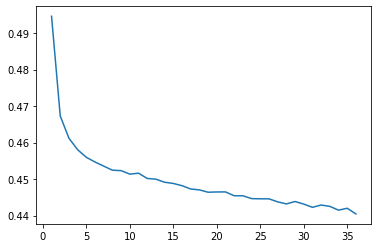

36


In [44]:
loss_train=loss_np[:best_epoch,0]
train_step=range(1,best_epoch+1)
plt.plot(train_step,loss_train)
plt.show()
print(len(loss_train))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


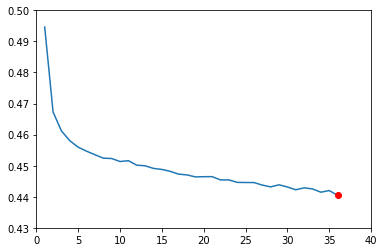

In [51]:
fig, ax = plt.subplots()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,40)
    ax.set_ylim(0.43,0.50)
    return l

def gen_dot():
    for i in range(1,best_epoch+1):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('loss.gif', writer='imagemagick', fps=30)

plt.show()

In [27]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

[[0.10806718 0.0221384  0.67581041 ... 0.50404466 0.41835862 0.24994773]
 [0.07938368 0.08695074 0.67827412 ... 0.55494359 0.42826787 0.08434809]
 [0.14713444 0.07670781 0.18427942 ... 0.68447931 0.34537285 0.07139748]
 ...
 [0.07070096 0.03819305 0.67877519 ... 0.69067021 0.54189151 0.20516175]
 [0.07516553 0.01247966 0.34838574 ... 0.47568343 0.40341294 0.18460261]
 [0.31462191 0.06859658 0.84317295 ... 0.64104624 0.6671439  0.050416  ]]
[[0.24056991 0.2782547  0.20873124 ... 0.56776604 0.29931715 0.23638323]
 [0.05400878 0.02471575 0.281767   ... 0.45249868 0.54884582 0.0567585 ]
 [0.01387425 0.02636357 0.67585237 ... 0.53860943 0.40094554 0.55899389]
 ...
 [0.03706912 0.02126497 0.70779724 ... 0.62629103 0.64399508 0.14916407]
 [0.01759261 0.03701945 0.30179983 ... 0.1849476  0.37799303 0.11765801]
 [0.03429722 0.01580314 0.69454218 ... 0.44835164 0.45501114 0.01243717]]


In [28]:
signalTensor= torch.tensor(signalSample1, dtype=torch.float,device=device)
backgroundTensor= torch.tensor(backgroundSample1, dtype=torch.float,device=device)
signalS=model(signalTensor)
backgroundS=model(backgroundTensor)
signalScore=signalS.data.cpu().numpy()
backgroundScore=backgroundS.data.cpu().numpy()


(array([ 7110., 14154., 12792., 11281.,  9172.,  7208.,  5722.,  4727.,
         4192.,  3705.,  3312.,  3026.,  2958.,  2491.,  1893.,  1618.,
         1495.,  1364.,  1402.,  1061.]),
 array([4.4662952e-06, 5.0003756e-02, 1.0000304e-01, 1.5000233e-01,
        2.0000161e-01, 2.5000089e-01, 3.0000019e-01, 3.4999949e-01,
        3.9999878e-01, 4.4999805e-01, 4.9999735e-01, 5.4999661e-01,
        5.9999591e-01, 6.4999521e-01, 6.9999450e-01, 7.4999380e-01,
        7.9999310e-01, 8.4999233e-01, 8.9999163e-01, 9.4999093e-01,
        9.9999022e-01], dtype=float32),
 <a list of 20 Patch objects>)

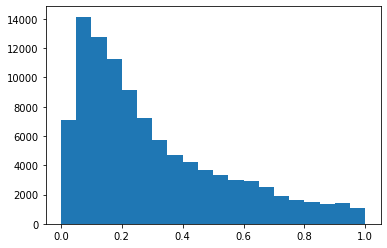

In [29]:
plt.hist(backgroundScore,bins=20)

(array([ 1289.,  2920.,  3831.,  4314.,  4759.,  4611.,  4371.,  4547.,
         4703.,  5121.,  5640.,  6499.,  8087.,  8362.,  8359.,  8839.,
        10365., 13699., 22757., 51496.]),
 array([0.00354376, 0.05336658, 0.10318939, 0.1530122 , 0.20283501,
        0.25265783, 0.30248064, 0.35230345, 0.40212625, 0.45194906,
        0.50177187, 0.5515947 , 0.6014175 , 0.6512403 , 0.70106316,
        0.75088596, 0.8007088 , 0.8505316 , 0.9003544 , 0.9501772 ,
        1.        ], dtype=float32),
 <a list of 20 Patch objects>)

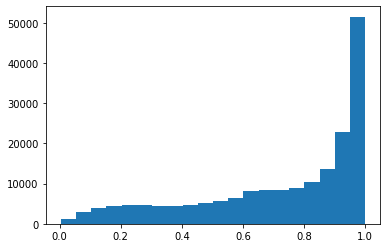

In [30]:
plt.hist(signalScore,bins=20)

In [31]:
plot_model(model, to_file='model_4l.png')

AttributeError: 'Net' object has no attribute 'layers'

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lNN.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=12))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

    

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)
eli5.show_weights(perm)

In [ ]:
eli5.show_weights(perm,feature_names=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"])

In [52]:
cuda.select_device(0)
cuda.close()

In [53]:
varname=["MJJ","MZZ","dYJJ","PtZZ","PtZ1","PtJ1","PtJ2","YJ1xJ2","PtL3","YZ1Star",
                                "YZ2Star","PtZZJJOHtZZJJ"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varname)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varname)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varname)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varname)
param = {'max_depth': 5, 'eta': 0.3, 'silent': 0, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'lossguide'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


In [54]:
num_round = 3000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.795824	train-auc:0.799379
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.807065	train-auc:0.810567
[2]	eval-auc:0.817526	train-auc:0.820216
[3]	eval-auc:0.824011	train-auc:0.826128
[4]	eval-auc:0.832098	train-auc:0.833865
[5]	eval-auc:0.838781	train-auc:0.839767
[6]	eval-auc:0.840425	train-auc:0.841894
[7]	eval-auc:0.847072	train-auc:0.848542
[8]	eval-auc:0.849033	train-auc:0.850755
[9]	eval-auc:0.852497	train-auc:0.854188
[10]	eval-auc:0.854286	train-auc:0.856013
[11]	eval-auc:0.856619	train-auc:0.85823
[12]	eval-auc:0.858149	train-auc:0.859702
[13]	eval-auc:0.859181	train-auc:0.860861
[14]	eval-auc:0.859774	train-auc:0.861444
[15]	eval-auc:0.860428	train-auc:0.862195
[16]	eval-auc:0.861339	train-auc:0.863168
[17]	eval-auc:0.861726	train-auc:0.863672
[18]	eval-auc:0.862135	train-auc:0.86411
[19]	eval-auc:0.862751	train-auc:0.864701
[20]	eval-auc:0.863085	train-

[191]	eval-auc:0.873772	train-auc:0.879256
[192]	eval-auc:0.873787	train-auc:0.879286
[193]	eval-auc:0.873788	train-auc:0.87932
[194]	eval-auc:0.87379	train-auc:0.879337
[195]	eval-auc:0.873804	train-auc:0.879375
[196]	eval-auc:0.873796	train-auc:0.879404
[197]	eval-auc:0.873819	train-auc:0.879428
[198]	eval-auc:0.873843	train-auc:0.879475
[199]	eval-auc:0.873854	train-auc:0.87951
[200]	eval-auc:0.873846	train-auc:0.879533
[201]	eval-auc:0.873854	train-auc:0.879566
[202]	eval-auc:0.873848	train-auc:0.879617
[203]	eval-auc:0.873858	train-auc:0.879643
[204]	eval-auc:0.873875	train-auc:0.879654
[205]	eval-auc:0.873869	train-auc:0.87967
[206]	eval-auc:0.873854	train-auc:0.879703
[207]	eval-auc:0.87385	train-auc:0.879719
[208]	eval-auc:0.873867	train-auc:0.879744
[209]	eval-auc:0.873877	train-auc:0.879779
[210]	eval-auc:0.873872	train-auc:0.879802
[211]	eval-auc:0.873894	train-auc:0.879838
[212]	eval-auc:0.873901	train-auc:0.879857
[213]	eval-auc:0.873913	train-auc:0.879896
[214]	eval-auc:0

[383]	eval-auc:0.874753	train-auc:0.883708
[384]	eval-auc:0.874745	train-auc:0.883739
[385]	eval-auc:0.874729	train-auc:0.883746
[386]	eval-auc:0.874788	train-auc:0.883776
[387]	eval-auc:0.8748	train-auc:0.883797
[388]	eval-auc:0.874771	train-auc:0.88382
[389]	eval-auc:0.874797	train-auc:0.88385
[390]	eval-auc:0.874814	train-auc:0.883873
[391]	eval-auc:0.874825	train-auc:0.883892
[392]	eval-auc:0.874798	train-auc:0.883898
[393]	eval-auc:0.874776	train-auc:0.883909
[394]	eval-auc:0.874779	train-auc:0.883933
[395]	eval-auc:0.874765	train-auc:0.88395
[396]	eval-auc:0.874773	train-auc:0.883968
[397]	eval-auc:0.874771	train-auc:0.883987
[398]	eval-auc:0.874792	train-auc:0.88401
[399]	eval-auc:0.874788	train-auc:0.884027
[400]	eval-auc:0.874799	train-auc:0.884052
[401]	eval-auc:0.874813	train-auc:0.884068
[402]	eval-auc:0.874807	train-auc:0.884082
[403]	eval-auc:0.874785	train-auc:0.8841
[404]	eval-auc:0.874791	train-auc:0.884115
[405]	eval-auc:0.874777	train-auc:0.884134
[406]	eval-auc:0.87

[575]	eval-auc:0.875248	train-auc:0.887123
[576]	eval-auc:0.875229	train-auc:0.887142
[577]	eval-auc:0.87523	train-auc:0.887159
[578]	eval-auc:0.875257	train-auc:0.887172
[579]	eval-auc:0.875267	train-auc:0.887191
[580]	eval-auc:0.875286	train-auc:0.887208
[581]	eval-auc:0.875279	train-auc:0.887216
[582]	eval-auc:0.875268	train-auc:0.887223
[583]	eval-auc:0.875268	train-auc:0.88725
[584]	eval-auc:0.875267	train-auc:0.887259
[585]	eval-auc:0.875274	train-auc:0.887279
[586]	eval-auc:0.875274	train-auc:0.887293
[587]	eval-auc:0.875278	train-auc:0.887304
[588]	eval-auc:0.875287	train-auc:0.887327
[589]	eval-auc:0.875285	train-auc:0.887347
[590]	eval-auc:0.875274	train-auc:0.887362
[591]	eval-auc:0.875282	train-auc:0.887377
[592]	eval-auc:0.875285	train-auc:0.887385
[593]	eval-auc:0.875274	train-auc:0.887404
[594]	eval-auc:0.875273	train-auc:0.887415
[595]	eval-auc:0.875262	train-auc:0.88743
[596]	eval-auc:0.875287	train-auc:0.887447
[597]	eval-auc:0.875279	train-auc:0.887465
[598]	eval-auc

[767]	eval-auc:0.875211	train-auc:0.889879
[768]	eval-auc:0.875216	train-auc:0.88989
[769]	eval-auc:0.875209	train-auc:0.889893
[770]	eval-auc:0.875209	train-auc:0.889902
[771]	eval-auc:0.875214	train-auc:0.88991
[772]	eval-auc:0.875218	train-auc:0.889927
[773]	eval-auc:0.875218	train-auc:0.889935
[774]	eval-auc:0.875225	train-auc:0.889952
[775]	eval-auc:0.875219	train-auc:0.889976
[776]	eval-auc:0.875242	train-auc:0.889986
[777]	eval-auc:0.875234	train-auc:0.889999
[778]	eval-auc:0.875212	train-auc:0.890012
[779]	eval-auc:0.875187	train-auc:0.890037
[780]	eval-auc:0.875235	train-auc:0.89005
[781]	eval-auc:0.875232	train-auc:0.89006
[782]	eval-auc:0.875234	train-auc:0.890059
[783]	eval-auc:0.875241	train-auc:0.890076
[784]	eval-auc:0.875267	train-auc:0.890093
[785]	eval-auc:0.875275	train-auc:0.890097
[786]	eval-auc:0.87529	train-auc:0.890107
[787]	eval-auc:0.875291	train-auc:0.890121
[788]	eval-auc:0.875284	train-auc:0.890129
[789]	eval-auc:0.875313	train-auc:0.890136
[790]	eval-auc:0

[959]	eval-auc:0.875253	train-auc:0.892272
[960]	eval-auc:0.875245	train-auc:0.892283
[961]	eval-auc:0.875241	train-auc:0.892295
[962]	eval-auc:0.875246	train-auc:0.892303
[963]	eval-auc:0.875251	train-auc:0.892313
[964]	eval-auc:0.875257	train-auc:0.892324
[965]	eval-auc:0.875261	train-auc:0.89232
[966]	eval-auc:0.875232	train-auc:0.892341
[967]	eval-auc:0.875244	train-auc:0.89234
[968]	eval-auc:0.875238	train-auc:0.892338
[969]	eval-auc:0.875247	train-auc:0.892355
[970]	eval-auc:0.875245	train-auc:0.892368
[971]	eval-auc:0.875264	train-auc:0.892375
[972]	eval-auc:0.875276	train-auc:0.892389
[973]	eval-auc:0.875273	train-auc:0.892405
[974]	eval-auc:0.875251	train-auc:0.892419
[975]	eval-auc:0.875241	train-auc:0.892446
[976]	eval-auc:0.875228	train-auc:0.892464
[977]	eval-auc:0.875253	train-auc:0.892488
[978]	eval-auc:0.875285	train-auc:0.892497
[979]	eval-auc:0.875272	train-auc:0.8925
[980]	eval-auc:0.875265	train-auc:0.892511
[981]	eval-auc:0.87528	train-auc:0.892539
[982]	eval-auc:0

[1148]	eval-auc:0.875124	train-auc:0.894396
[1149]	eval-auc:0.87514	train-auc:0.894412
[1150]	eval-auc:0.875143	train-auc:0.894417
[1151]	eval-auc:0.875129	train-auc:0.894426
[1152]	eval-auc:0.875123	train-auc:0.89444
[1153]	eval-auc:0.875123	train-auc:0.894448
[1154]	eval-auc:0.875155	train-auc:0.894468
[1155]	eval-auc:0.875162	train-auc:0.894486
[1156]	eval-auc:0.875139	train-auc:0.894503
[1157]	eval-auc:0.875148	train-auc:0.894516
[1158]	eval-auc:0.875111	train-auc:0.89452
[1159]	eval-auc:0.875084	train-auc:0.894539
[1160]	eval-auc:0.875068	train-auc:0.894552
[1161]	eval-auc:0.875052	train-auc:0.894565
[1162]	eval-auc:0.875053	train-auc:0.894583
[1163]	eval-auc:0.875028	train-auc:0.894588
[1164]	eval-auc:0.875044	train-auc:0.894603
[1165]	eval-auc:0.875045	train-auc:0.894618
[1166]	eval-auc:0.875055	train-auc:0.894618
[1167]	eval-auc:0.875043	train-auc:0.894619
[1168]	eval-auc:0.875046	train-auc:0.894627
[1169]	eval-auc:0.875037	train-auc:0.894633
[1170]	eval-auc:0.875052	train-auc:

[1336]	eval-auc:0.874895	train-auc:0.896415
[1337]	eval-auc:0.874902	train-auc:0.896433
[1338]	eval-auc:0.874876	train-auc:0.896443
[1339]	eval-auc:0.874873	train-auc:0.896455
[1340]	eval-auc:0.874848	train-auc:0.896463
[1341]	eval-auc:0.874832	train-auc:0.896476
[1342]	eval-auc:0.874827	train-auc:0.896491
[1343]	eval-auc:0.874836	train-auc:0.896494
[1344]	eval-auc:0.874814	train-auc:0.896511
[1345]	eval-auc:0.874838	train-auc:0.896527
[1346]	eval-auc:0.874857	train-auc:0.89653
[1347]	eval-auc:0.874865	train-auc:0.896547
[1348]	eval-auc:0.874845	train-auc:0.896565
[1349]	eval-auc:0.874853	train-auc:0.896594
[1350]	eval-auc:0.874849	train-auc:0.89659
[1351]	eval-auc:0.874837	train-auc:0.896612
[1352]	eval-auc:0.874819	train-auc:0.896625
[1353]	eval-auc:0.874833	train-auc:0.89663
[1354]	eval-auc:0.87482	train-auc:0.896655
[1355]	eval-auc:0.874801	train-auc:0.896672
[1356]	eval-auc:0.874803	train-auc:0.896678
[1357]	eval-auc:0.874784	train-auc:0.896694
[1358]	eval-auc:0.874823	train-auc:0

[1524]	eval-auc:0.874443	train-auc:0.898433
[1525]	eval-auc:0.874464	train-auc:0.898462
[1526]	eval-auc:0.874463	train-auc:0.898465
[1527]	eval-auc:0.874445	train-auc:0.898472
[1528]	eval-auc:0.874443	train-auc:0.898481
[1529]	eval-auc:0.874447	train-auc:0.898499
[1530]	eval-auc:0.874474	train-auc:0.898484
[1531]	eval-auc:0.874503	train-auc:0.89848
[1532]	eval-auc:0.874514	train-auc:0.898491
[1533]	eval-auc:0.874502	train-auc:0.898485
[1534]	eval-auc:0.874503	train-auc:0.898503
[1535]	eval-auc:0.8745	train-auc:0.898505
[1536]	eval-auc:0.874484	train-auc:0.898507
[1537]	eval-auc:0.874488	train-auc:0.898527
[1538]	eval-auc:0.874463	train-auc:0.898531
[1539]	eval-auc:0.874454	train-auc:0.898533
[1540]	eval-auc:0.874471	train-auc:0.898537
[1541]	eval-auc:0.874452	train-auc:0.898557
[1542]	eval-auc:0.874426	train-auc:0.898579
[1543]	eval-auc:0.874393	train-auc:0.898605
[1544]	eval-auc:0.874377	train-auc:0.898617
[1545]	eval-auc:0.874382	train-auc:0.898628
[1546]	eval-auc:0.874397	train-auc:

[1711]	eval-auc:0.874195	train-auc:0.900199
[1712]	eval-auc:0.874194	train-auc:0.900208
[1713]	eval-auc:0.874188	train-auc:0.900238
[1714]	eval-auc:0.8742	train-auc:0.900249
[1715]	eval-auc:0.874193	train-auc:0.900259
[1716]	eval-auc:0.874186	train-auc:0.900249
[1717]	eval-auc:0.87418	train-auc:0.900253
[1718]	eval-auc:0.874122	train-auc:0.900278
[1719]	eval-auc:0.874128	train-auc:0.900277
[1720]	eval-auc:0.874138	train-auc:0.900293
[1721]	eval-auc:0.874135	train-auc:0.900304
[1722]	eval-auc:0.874137	train-auc:0.900309
[1723]	eval-auc:0.874147	train-auc:0.900299
[1724]	eval-auc:0.874157	train-auc:0.900308
[1725]	eval-auc:0.874173	train-auc:0.900311
[1726]	eval-auc:0.874176	train-auc:0.900343
[1727]	eval-auc:0.874173	train-auc:0.90034
[1728]	eval-auc:0.874178	train-auc:0.90035
[1729]	eval-auc:0.874166	train-auc:0.900368
[1730]	eval-auc:0.874176	train-auc:0.900373
[1731]	eval-auc:0.874146	train-auc:0.900379
[1732]	eval-auc:0.874137	train-auc:0.900392
[1733]	eval-auc:0.874134	train-auc:0.

[1899]	eval-auc:0.873724	train-auc:0.901975
[1900]	eval-auc:0.873738	train-auc:0.901979
[1901]	eval-auc:0.87373	train-auc:0.901987
[1902]	eval-auc:0.873738	train-auc:0.901999
[1903]	eval-auc:0.873732	train-auc:0.902011
[1904]	eval-auc:0.873709	train-auc:0.902029
[1905]	eval-auc:0.873702	train-auc:0.902043
[1906]	eval-auc:0.873694	train-auc:0.902055
[1907]	eval-auc:0.873687	train-auc:0.902082
[1908]	eval-auc:0.873704	train-auc:0.90209
[1909]	eval-auc:0.873719	train-auc:0.902092
[1910]	eval-auc:0.873706	train-auc:0.902116
[1911]	eval-auc:0.873719	train-auc:0.902113
[1912]	eval-auc:0.873691	train-auc:0.902126
[1913]	eval-auc:0.873681	train-auc:0.902123
[1914]	eval-auc:0.87368	train-auc:0.90211
[1915]	eval-auc:0.873676	train-auc:0.90212
[1916]	eval-auc:0.87368	train-auc:0.902131
[1917]	eval-auc:0.873642	train-auc:0.902135
[1918]	eval-auc:0.873649	train-auc:0.902146
[1919]	eval-auc:0.873621	train-auc:0.902158
[1920]	eval-auc:0.873628	train-auc:0.902185
[1921]	eval-auc:0.873633	train-auc:0.9

[2087]	eval-auc:0.873478	train-auc:0.903605
[2088]	eval-auc:0.873501	train-auc:0.903608
[2089]	eval-auc:0.873506	train-auc:0.903628
[2090]	eval-auc:0.8735	train-auc:0.903624
[2091]	eval-auc:0.873493	train-auc:0.903629
[2092]	eval-auc:0.873486	train-auc:0.903625
[2093]	eval-auc:0.873458	train-auc:0.903637
[2094]	eval-auc:0.87346	train-auc:0.90365
[2095]	eval-auc:0.873447	train-auc:0.903662
[2096]	eval-auc:0.873463	train-auc:0.903658
[2097]	eval-auc:0.873469	train-auc:0.903662
[2098]	eval-auc:0.873469	train-auc:0.903682
[2099]	eval-auc:0.87348	train-auc:0.903688
[2100]	eval-auc:0.873465	train-auc:0.903707
[2101]	eval-auc:0.873462	train-auc:0.903715
[2102]	eval-auc:0.873437	train-auc:0.903722
[2103]	eval-auc:0.873439	train-auc:0.903728
[2104]	eval-auc:0.873433	train-auc:0.90374
[2105]	eval-auc:0.873423	train-auc:0.903759
[2106]	eval-auc:0.873435	train-auc:0.903788
[2107]	eval-auc:0.87342	train-auc:0.903803
[2108]	eval-auc:0.873424	train-auc:0.903807
[2109]	eval-auc:0.873439	train-auc:0.90

[2274]	eval-auc:0.873099	train-auc:0.90514
[2275]	eval-auc:0.873083	train-auc:0.905126
[2276]	eval-auc:0.873076	train-auc:0.905123
[2277]	eval-auc:0.873121	train-auc:0.905118
[2278]	eval-auc:0.873126	train-auc:0.905133
[2279]	eval-auc:0.873121	train-auc:0.905157
[2280]	eval-auc:0.873124	train-auc:0.905173
[2281]	eval-auc:0.873094	train-auc:0.905194
[2282]	eval-auc:0.873069	train-auc:0.905208
[2283]	eval-auc:0.87307	train-auc:0.905227
[2284]	eval-auc:0.873106	train-auc:0.905251
[2285]	eval-auc:0.873116	train-auc:0.905246
[2286]	eval-auc:0.873124	train-auc:0.905257
[2287]	eval-auc:0.873123	train-auc:0.905251
[2288]	eval-auc:0.873126	train-auc:0.905265
[2289]	eval-auc:0.873165	train-auc:0.905269
[2290]	eval-auc:0.873153	train-auc:0.90527
[2291]	eval-auc:0.87317	train-auc:0.905273
[2292]	eval-auc:0.873173	train-auc:0.905285
[2293]	eval-auc:0.873135	train-auc:0.9053
[2294]	eval-auc:0.873116	train-auc:0.905329
[2295]	eval-auc:0.873101	train-auc:0.905336
[2296]	eval-auc:0.873145	train-auc:0.9

[2462]	eval-auc:0.872838	train-auc:0.906576
[2463]	eval-auc:0.872789	train-auc:0.906596
[2464]	eval-auc:0.87282	train-auc:0.906596
[2465]	eval-auc:0.872813	train-auc:0.906618
[2466]	eval-auc:0.872758	train-auc:0.906614
[2467]	eval-auc:0.872732	train-auc:0.906653
[2468]	eval-auc:0.872738	train-auc:0.906653
[2469]	eval-auc:0.872756	train-auc:0.906653
[2470]	eval-auc:0.872776	train-auc:0.906658
[2471]	eval-auc:0.872778	train-auc:0.906659
[2472]	eval-auc:0.872778	train-auc:0.906692
[2473]	eval-auc:0.872771	train-auc:0.9067
[2474]	eval-auc:0.872733	train-auc:0.906718
[2475]	eval-auc:0.872703	train-auc:0.906754
[2476]	eval-auc:0.872724	train-auc:0.906754
[2477]	eval-auc:0.872716	train-auc:0.906755
[2478]	eval-auc:0.872729	train-auc:0.906747
[2479]	eval-auc:0.872732	train-auc:0.906764
[2480]	eval-auc:0.87276	train-auc:0.906771
[2481]	eval-auc:0.872751	train-auc:0.906763
[2482]	eval-auc:0.872736	train-auc:0.906774
[2483]	eval-auc:0.872746	train-auc:0.906775
[2484]	eval-auc:0.872763	train-auc:0

[2650]	eval-auc:0.872035	train-auc:0.90809
[2651]	eval-auc:0.872026	train-auc:0.90809
[2652]	eval-auc:0.872054	train-auc:0.9081
[2653]	eval-auc:0.872054	train-auc:0.908103
[2654]	eval-auc:0.872051	train-auc:0.90812
[2655]	eval-auc:0.872032	train-auc:0.908127
[2656]	eval-auc:0.872061	train-auc:0.908145
[2657]	eval-auc:0.872064	train-auc:0.908164
[2658]	eval-auc:0.872056	train-auc:0.908164
[2659]	eval-auc:0.872076	train-auc:0.908178
[2660]	eval-auc:0.872098	train-auc:0.908176
[2661]	eval-auc:0.872102	train-auc:0.908181
[2662]	eval-auc:0.872118	train-auc:0.908164
[2663]	eval-auc:0.872115	train-auc:0.908166
[2664]	eval-auc:0.872113	train-auc:0.908187
[2665]	eval-auc:0.872107	train-auc:0.908179
[2666]	eval-auc:0.872086	train-auc:0.908193
[2667]	eval-auc:0.87211	train-auc:0.908196
[2668]	eval-auc:0.872077	train-auc:0.90822
[2669]	eval-auc:0.872105	train-auc:0.908219
[2670]	eval-auc:0.872108	train-auc:0.908225
[2671]	eval-auc:0.87211	train-auc:0.908232
[2672]	eval-auc:0.872102	train-auc:0.908

[2838]	eval-auc:0.87175	train-auc:0.909527
[2839]	eval-auc:0.871763	train-auc:0.909535
[2840]	eval-auc:0.871774	train-auc:0.909531
[2841]	eval-auc:0.871783	train-auc:0.909518
[2842]	eval-auc:0.871785	train-auc:0.909518
[2843]	eval-auc:0.871786	train-auc:0.909522
[2844]	eval-auc:0.871777	train-auc:0.909523
[2845]	eval-auc:0.871776	train-auc:0.909499
[2846]	eval-auc:0.871764	train-auc:0.909502
[2847]	eval-auc:0.87175	train-auc:0.909516
[2848]	eval-auc:0.871756	train-auc:0.909515
[2849]	eval-auc:0.871749	train-auc:0.909514
Stopping. Best iteration:
[2839]	eval-auc:0.871763	train-auc:0.909535



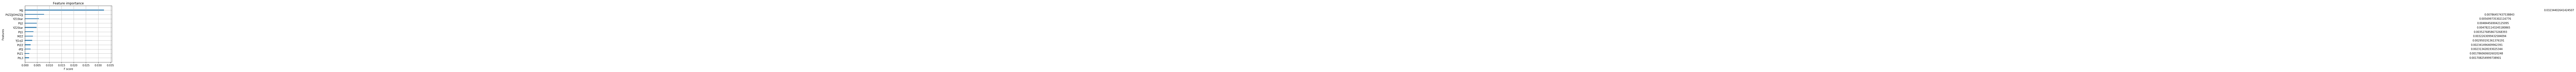

In [55]:
xgb.plot_importance(GBDT,importance_type="gain")

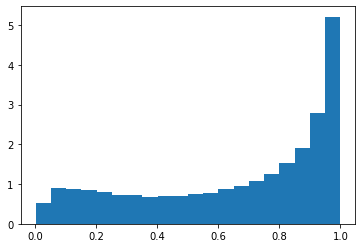

In [56]:
SignalScore=GBDT.predict(BDTSignal)
plt.hist(SignalScore,bins=20,weights=signalArray[:,0])
BackgroundScore=GBDT.predict(BDTBackground)
#plt.hist(BackgroundScore,bins=20)

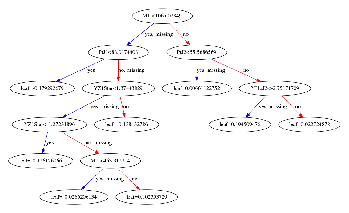

In [57]:
plot_tree(GBDT, num_trees=4)

(array([ 8.47697222, 10.24602184,  8.87116326,  7.54072445,  6.48962659,
         5.59213752,  5.1279112 ,  4.33169776,  4.1520057 ,  3.91900657,
         3.77743301,  3.65810489,  3.71584467,  3.81118293,  4.13623336,
         4.53782453,  5.22317843,  6.25472636,  8.86277514, 15.59253244]),
 array([0.00230502, 0.05217771, 0.1020504 , 0.1519231 , 0.20179579,
        0.25166848, 0.30154118, 0.35141388, 0.40128657, 0.45115927,
        0.50103194, 0.55090463, 0.6007773 , 0.65065   , 0.7005227 ,
        0.7503954 , 0.8002681 , 0.8501408 , 0.9000135 , 0.9498862 ,
        0.9997589 ], dtype=float32),
 <a list of 20 Patch objects>)

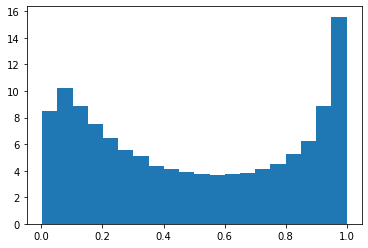

In [58]:
trainScore=GBDT.predict(BDTtrain)
plt.hist(trainScore,bins=20,weights=dataTrainWeight)

In [59]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

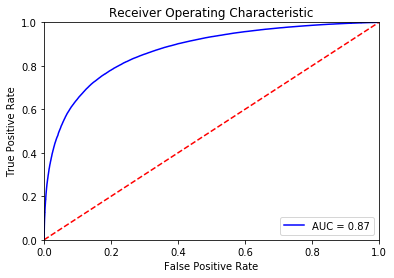

In [60]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_vbszz.pickle.dat", "wb"))